# Demonstrace funkcionality balíčku `gradsolv`

### Import balíčků (včetně balíčku `gradsolv`)

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import gradsolv as grad

### Deklarace řešičů a předpodmíňovačů

In [2]:
# Resice
solver_sd = grad.steepest_descend_solver() # Metoda nejvetsiho spadu
solver_cg = grad.conjugate_gradient_solver() # Metoda sdruzenych gradientu

# Predpodminovace
preconditioner_diag = grad.diagonal_preconditioner() # Diagonalni predpodminovac (M^(-1) = D^(-1))
preconditioner_gs_DLDLT = grad.gauss_seidel_DLDLT_preconditioner() # Gauss-Seidel predpodminovac (M^(-1) = (D + L/2)^(-1) * (D - L^(T)/2))
preconditioner_gs_LDDLD = grad.gauss_seidel_LDDLD_preconditioner() # Gauss-Seidel predpodminovac (M^(-1) = (L + D)^(-1) * D * (L + D)^(-T))

### Deklarace vektoru pravé strany

In [3]:
vec_b = np.array([18, 15, 2, 6, 18, 6, 7, 9, 7, 10], dtype=int)

### Cesta k testovacím datům

In [4]:
data_path = Path("./data/")

### Ukázka odchycení chyby a vyhození vyjímky

In [5]:
# Nacteni nesymetricke matice
mat_not_symmetric = np.load(data_path.joinpath("mat_not_symmetric.npy"))

print(mat_not_symmetric)

[[ 9  0  0  0  0  0  0  0  0  0]
 [ 1  6  0  0  0  0  0  0  0  0]
 [-3 -3  8  0  0  0  0  0  0  0]
 [-2 -5  4  9  0  0  0  0  0  0]
 [-5 -5  3  4  6  0  0  0  0  0]
 [ 1  2 -5 -5  2  6  0  0  0  0]
 [ 2 -2  0  3  4 -2  6  0  0  0]
 [-1 -4 -1  4  3 -5  1  9  0  0]
 [-5  0  3  1  3  2  3  1  9  0]
 [ 0  0 -3 -3  3  0 -5 -5 -1  7]]


In [6]:
err_handle = grad.error_handle()

solver_cg.set_preconditioner(None)
result = solver_cg.solve(matrix=mat_not_symmetric, rhs=vec_b, error_handle=err_handle, tol=1e-8, max_it=10000, include_relres_vec=False)

# Vyhodi se vyjimka GradSolvError s prislusnou chybovou hlaskou
grad.chkerr(error_handle=err_handle)

GradSolvError: Matrix must be symmetric!

### Příklad č.1 (`mat_A`)

In [7]:
# Nacteni matice
mat_A = np.load(data_path.joinpath("mat_A.npy"))

print(mat_A)

[[2352    4    0    1    3   -5   -2    3   -3   -1]
 [   4 4463   -2   -2   -5    1   -5   -5   -3   -2]
 [   0   -2 2248    3    4    0   -5    0    2   -5]
 [   1   -2    3 3819   -3    0    3   -3   -3    1]
 [   3   -5    4   -3 2116    1    3   -1   -5   -4]
 [  -5    1    0    0    1 4344   -3   -4   -2   -3]
 [  -2   -5   -5    3    3   -3 1200    4   -4   -3]
 [   3   -5    0   -3   -1   -4    4 2221    0   -2]
 [  -3   -3    2   -3   -5   -2   -4    0 2743   -2]
 [  -1   -2   -5    1   -4   -3   -3   -2   -2 3206]]


#### Řešení soustavy s maticí `mat_A` pomocí metody největšího spádu (bez a s použitím daných předpodmíňovačů)

In [8]:
matrix = mat_A
rhs = vec_b
err_handle = grad.error_handle()
tol = 1e-48
max_it = 10000
include_relres_vec = True

solver_sd.set_preconditioner(None)
result_sd_not_prec = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_diag)
result_sd_diag = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_gs_DLDLT)
result_sd_gs_DLDLT = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_gs_LDDLD)
result_sd_gs_LDDLD = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci (sd_not_prec): {result_sd_not_prec.iterations}")
print(f"Pocet iteraci (sd_diag): {result_sd_diag.iterations}")
print(f"Pocet iteraci (sd_gs_DLDLT): {result_sd_gs_DLDLT.iterations}")
print(f"Pocet iteraci (sd_gs_LDDLD): {result_sd_gs_LDDLD.iterations}")

Pocet iteraci (sd_not_prec): 192
Pocet iteraci (sd_diag): 22
Pocet iteraci (sd_gs_DLDLT): 182
Pocet iteraci (sd_gs_LDDLD): 10


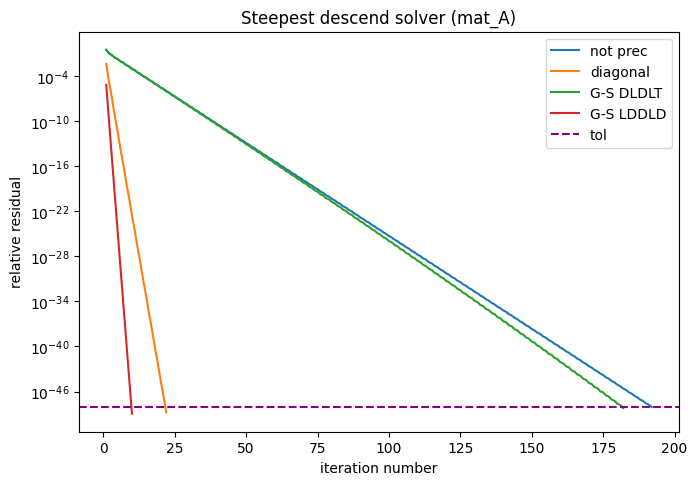

In [9]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Steepest descend solver (mat_A)")

ax.plot(np.arange(1, result_sd_not_prec.relres_vec.shape[0] + 1), result_sd_not_prec.relres_vec, label="not prec")
ax.plot(np.arange(1, result_sd_diag.relres_vec.shape[0] + 1), result_sd_diag.relres_vec, label="diagonal")
ax.plot(np.arange(1, result_sd_gs_DLDLT.relres_vec.shape[0] + 1), result_sd_gs_DLDLT.relres_vec, label="G-S DLDLT")
ax.plot(np.arange(1, result_sd_gs_LDDLD.relres_vec.shape[0] + 1), result_sd_gs_LDDLD.relres_vec, label="G-S LDDLD")
ax.axhline(y=tol, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()

#### Řešení soustavy s maticí `mat_A` pomocí metody sdružených gradientů (bez a s použitím daných předpodmíňovačů)

In [10]:
matrix = mat_A
rhs = vec_b
err_handle = grad.error_handle()
tol = 1e-48
max_it = 10000
include_relres_vec = True

solver_cg.set_preconditioner(None)
result_cg_not_prec = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_diag)
result_cg_diag = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_gs_DLDLT)
result_cg_gs_DLDLT = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_gs_LDDLD)
result_cg_gs_LDDLD = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci (cg_not_prec): {result_cg_not_prec.iterations}")
print(f"Pocet iteraci (cg_diag): {result_cg_diag.iterations}")
print(f"Pocet iteraci (cg_gs_DLDLT): {result_cg_gs_DLDLT.iterations}")
print(f"Pocet iteraci (cg_gs_LDDLD): {result_cg_gs_LDDLD.iterations}")

Pocet iteraci (cg_not_prec): 27
Pocet iteraci (cg_diag): 15
Pocet iteraci (cg_gs_DLDLT): 67
Pocet iteraci (cg_gs_LDDLD): 9


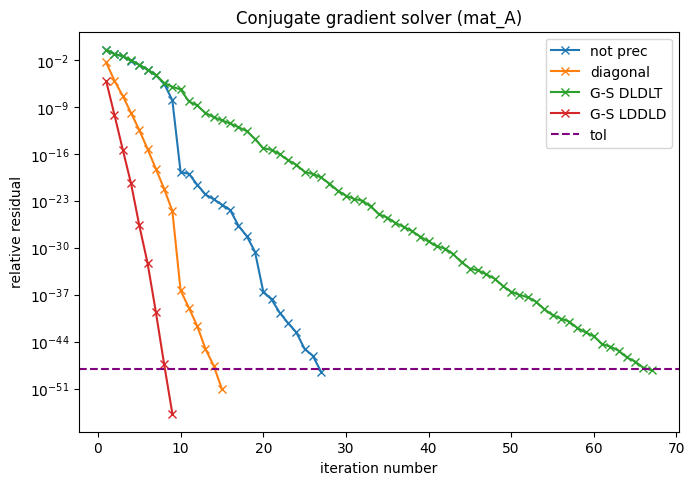

In [11]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Conjugate gradient solver (mat_A)")

ax.plot(np.arange(1, result_cg_not_prec.relres_vec.shape[0] + 1), result_cg_not_prec.relres_vec, label="not prec", marker="x")
ax.plot(np.arange(1, result_cg_diag.relres_vec.shape[0] + 1), result_cg_diag.relres_vec, label="diagonal", marker="x")
ax.plot(np.arange(1, result_cg_gs_DLDLT.relres_vec.shape[0] + 1), result_cg_gs_DLDLT.relres_vec, label="G-S DLDLT", marker="x")
ax.plot(np.arange(1, result_cg_gs_LDDLD.relres_vec.shape[0] + 1), result_cg_gs_LDDLD.relres_vec, label="G-S LDDLD", marker="x")
ax.axhline(y=tol, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()

### Příklad č.2 (`mat_B`)

In [12]:
# Nacteni matice
mat_B = np.load(data_path.joinpath("mat_B.npy"))

print(mat_B)

[[386  -3   4  -4   0   4   0  -2   2   4]
 [ -3 450  -5   3  -3  -3  -5   1   0  -1]
 [  4  -5 473   3  -2  -4  -1   2   0  -3]
 [ -4   3   3 300  -1  -4  -2  -2  -3   2]
 [  0  -3  -2  -1 438  -1   1   4  -1  -3]
 [  4  -3  -4  -4  -1 153   0   3  -2  -3]
 [  0  -5  -1  -2   1   0 110  -4  -2   3]
 [ -2   1   2  -2   4   3  -4 359  -5   4]
 [  2   0   0  -3  -1  -2  -2  -5 489  -5]
 [  4  -1  -3   2  -3  -3   3   4  -5 314]]


#### Řešení soustavy s maticí `mat_B` pomocí metody největšího spádu (bez a s použitím daných předpodmíňovačů)

In [13]:
matrix = mat_B
rhs = vec_b
err_handle = grad.error_handle()
tol = 1e-48
max_it = 10000
include_relres_vec = True

solver_sd.set_preconditioner(None)
result_sd_not_prec = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_diag)
result_sd_diag = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_gs_DLDLT)
result_sd_gs_DLDLT = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_gs_LDDLD)
result_sd_gs_LDDLD = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci (sd_not_prec): {result_sd_not_prec.iterations}")
print(f"Pocet iteraci (sd_diag): {result_sd_diag.iterations}")
print(f"Pocet iteraci (sd_gs_DLDLT): {result_sd_gs_DLDLT.iterations}")
print(f"Pocet iteraci (sd_gs_LDDLD): {result_sd_gs_LDDLD.iterations}")

Pocet iteraci (sd_not_prec): 226
Pocet iteraci (sd_diag): 36
Pocet iteraci (sd_gs_DLDLT): 189
Pocet iteraci (sd_gs_LDDLD): 16


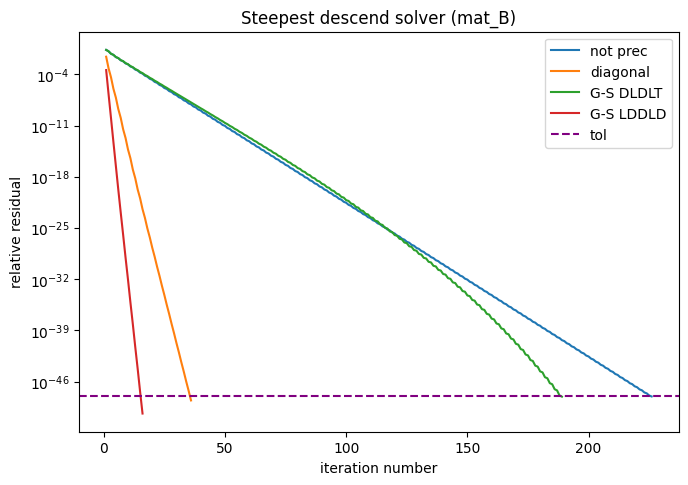

In [14]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Steepest descend solver (mat_B)")

ax.plot(np.arange(1, result_sd_not_prec.relres_vec.shape[0] + 1), result_sd_not_prec.relres_vec, label="not prec")
ax.plot(np.arange(1, result_sd_diag.relres_vec.shape[0] + 1), result_sd_diag.relres_vec, label="diagonal")
ax.plot(np.arange(1, result_sd_gs_DLDLT.relres_vec.shape[0] + 1), result_sd_gs_DLDLT.relres_vec, label="G-S DLDLT")
ax.plot(np.arange(1, result_sd_gs_LDDLD.relres_vec.shape[0] + 1), result_sd_gs_LDDLD.relres_vec, label="G-S LDDLD")
ax.axhline(y=tol, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()

#### Řešení soustavy s maticí `mat_B` pomocí metody sdružených gradientů (bez a s použitím daných předpodmíňovačů)

In [15]:
matrix = mat_B
rhs = vec_b
err_handle = grad.error_handle()
tol = 1e-48
max_it = 10000
include_relres_vec = True

solver_cg.set_preconditioner(None)
result_cg_not_prec = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_diag)
result_cg_diag = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_gs_DLDLT)
result_cg_gs_DLDLT = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_gs_LDDLD)
result_cg_gs_LDDLD = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci (cg_not_prec): {result_cg_not_prec.iterations}")
print(f"Pocet iteraci (cg_diag): {result_cg_diag.iterations}")
print(f"Pocet iteraci (cg_gs_DLDLT): {result_cg_gs_DLDLT.iterations}")
print(f"Pocet iteraci (cg_gs_LDDLD): {result_cg_gs_LDDLD.iterations}")

Pocet iteraci (cg_not_prec): 29
Pocet iteraci (cg_diag): 20
Pocet iteraci (cg_gs_DLDLT): 83
Pocet iteraci (cg_gs_LDDLD): 11


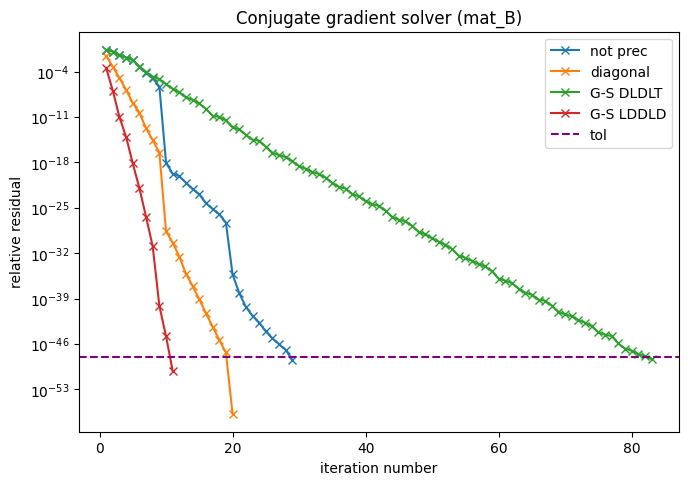

In [16]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Conjugate gradient solver (mat_B)")

ax.plot(np.arange(1, result_cg_not_prec.relres_vec.shape[0] + 1), result_cg_not_prec.relres_vec, label="not prec", marker="x")
ax.plot(np.arange(1, result_cg_diag.relres_vec.shape[0] + 1), result_cg_diag.relres_vec, label="diagonal", marker="x")
ax.plot(np.arange(1, result_cg_gs_DLDLT.relres_vec.shape[0] + 1), result_cg_gs_DLDLT.relres_vec, label="G-S DLDLT", marker="x")
ax.plot(np.arange(1, result_cg_gs_LDDLD.relres_vec.shape[0] + 1), result_cg_gs_LDDLD.relres_vec, label="G-S LDDLD", marker="x")
ax.axhline(y=tol, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()

### Příklad č.3 (`mat_C`)

In [17]:
# Nacteni matice
mat_C = np.load(data_path.joinpath("mat_C.npy"))

print(mat_C)

[[17  3  1  3  3  4  2  3  3  3]
 [ 3 13  1  4  3  3  1  1  1  1]
 [ 1  1 17  3  3  1  3  1  1  1]
 [ 3  4  3 17  4  1  2  2  1  4]
 [ 3  3  3  4 15  3  1  4  1  2]
 [ 4  3  1  1  3 12  4  3  4  3]
 [ 2  1  3  2  1  4 16  1  2  2]
 [ 3  1  1  2  4  3  1 17  3  3]
 [ 3  1  1  1  1  4  2  3 10  2]
 [ 3  1  1  4  2  3  2  3  2 16]]


#### Řešení soustavy s maticí `mat_C` pomocí metody největšího spádu (bez a s použitím daných předpodmíňovačů)

In [18]:
matrix = mat_C
rhs = vec_b
err_handle = grad.error_handle()
tol = 1e-48
max_it = 10000
include_relres_vec = True

solver_sd.set_preconditioner(None)
result_sd_not_prec = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_diag)
result_sd_diag = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_gs_DLDLT)
result_sd_gs_DLDLT = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_sd.set_preconditioner(preconditioner_gs_LDDLD)
result_sd_gs_LDDLD = solver_sd.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci (sd_not_prec): {result_sd_not_prec.iterations}")
print(f"Pocet iteraci (sd_diag): {result_sd_diag.iterations}")
print(f"Pocet iteraci (sd_gs_DLDLT): {result_sd_gs_DLDLT.iterations}")
print(f"Pocet iteraci (sd_gs_LDDLD): {result_sd_gs_LDDLD.iterations}")

Pocet iteraci (sd_not_prec): 279
Pocet iteraci (sd_diag): 225
Pocet iteraci (sd_gs_DLDLT): 117
Pocet iteraci (sd_gs_LDDLD): 73


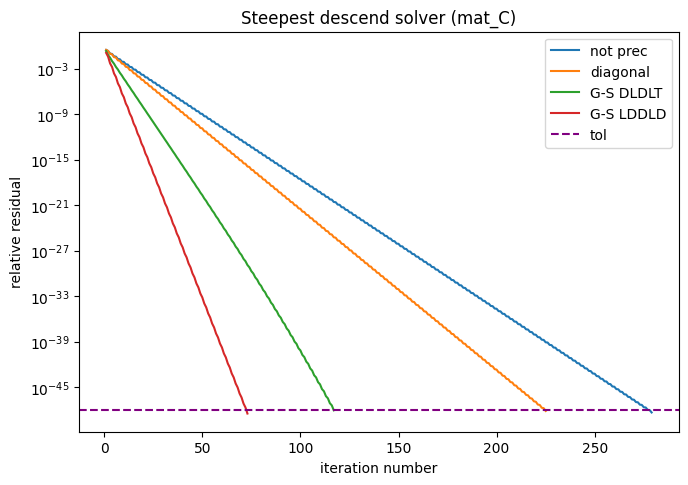

In [19]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Steepest descend solver (mat_C)")

ax.plot(np.arange(1, result_sd_not_prec.relres_vec.shape[0] + 1), result_sd_not_prec.relres_vec, label="not prec")
ax.plot(np.arange(1, result_sd_diag.relres_vec.shape[0] + 1), result_sd_diag.relres_vec, label="diagonal")
ax.plot(np.arange(1, result_sd_gs_DLDLT.relres_vec.shape[0] + 1), result_sd_gs_DLDLT.relres_vec, label="G-S DLDLT")
ax.plot(np.arange(1, result_sd_gs_LDDLD.relres_vec.shape[0] + 1), result_sd_gs_LDDLD.relres_vec, label="G-S LDDLD")
ax.axhline(y=tol, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()

#### Řešení soustavy s maticí `mat_C` pomocí metody sdružených gradientů (bez a s použitím daných předpodmíňovačů)

In [20]:
matrix = mat_C
rhs = vec_b
err_handle = grad.error_handle()
tol = 1e-48
max_it = 10000
include_relres_vec = True

solver_cg.set_preconditioner(None)
result_cg_not_prec = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_diag)
result_cg_diag = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_gs_DLDLT)
result_cg_gs_DLDLT = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

solver_cg.set_preconditioner(preconditioner_gs_LDDLD)
result_cg_gs_LDDLD = solver_cg.solve(matrix, rhs, err_handle, tol, max_it, include_relres_vec)
grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci (cg_not_prec): {result_cg_not_prec.iterations}")
print(f"Pocet iteraci (cg_diag): {result_cg_diag.iterations}")
print(f"Pocet iteraci (cg_gs_DLDLT): {result_cg_gs_DLDLT.iterations}")
print(f"Pocet iteraci (cg_gs_LDDLD): {result_cg_gs_LDDLD.iterations}")

Pocet iteraci (cg_not_prec): 31
Pocet iteraci (cg_diag): 28
Pocet iteraci (cg_gs_DLDLT): 746
Pocet iteraci (cg_gs_LDDLD): 22


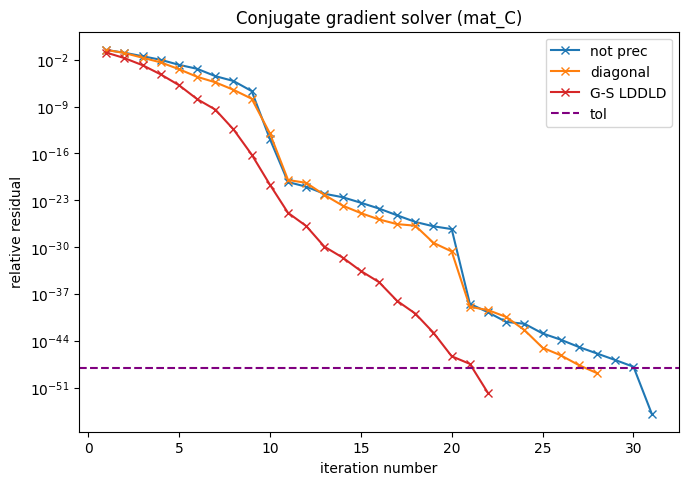

In [21]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Conjugate gradient solver (mat_C)")

ax.plot(np.arange(1, result_cg_not_prec.relres_vec.shape[0] + 1), result_cg_not_prec.relres_vec, label="not prec", marker="x")
ax.plot(np.arange(1, result_cg_diag.relres_vec.shape[0] + 1), result_cg_diag.relres_vec, label="diagonal", marker="x")
#ax.plot(np.arange(1, result_cg_gs_DLDLT.relres_vec.shape[0] + 1), result_cg_gs_DLDLT.relres_vec, label="G-S DLDLT", marker="x")
ax.plot(np.arange(1, result_cg_gs_LDDLD.relres_vec.shape[0] + 1), result_cg_gs_LDDLD.relres_vec, label="G-S LDDLD", marker="x", color="tab:red")
ax.axhline(y=tol, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()

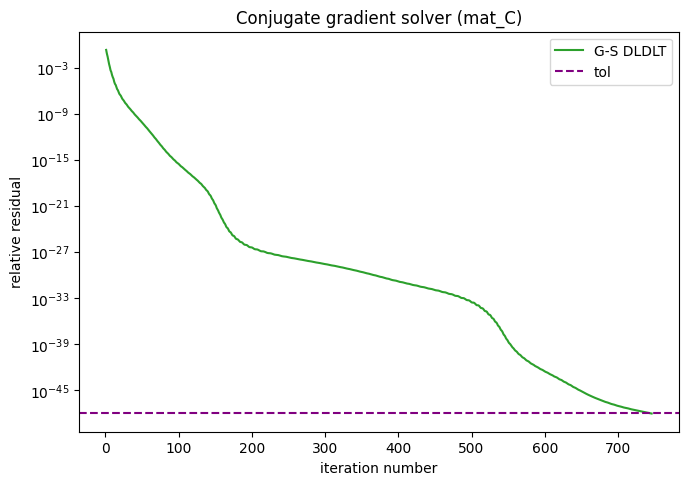

In [22]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Conjugate gradient solver (mat_C)")

ax.plot(np.arange(1, result_cg_gs_DLDLT.relres_vec.shape[0] + 1), result_cg_gs_DLDLT.relres_vec, label="G-S DLDLT", color="tab:green")
ax.axhline(y=tol, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()